In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [2]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    'character_name': ['PIKACHU'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [3]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
dataset.dataset.head()

PIKACHU    4096
Name: labels, dtype: int64


/workspace/slp_jaspar/anomaly_detection_minute/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,PIKACHU,HUMAN,HUMAN,mango\PIKACHU\daa0e300-d731-42ea-a634-28c9db71...,7244,PIKACHU
1,POKEMON_STADIUM,2,True,PIKACHU,HUMAN,HUMAN,mango\PIKACHU\142d032c-4d4a-4056-b9a9-aca37c88...,7384,PIKACHU
2,YOSHIS_STORY,2,True,PIKACHU,HUMAN,HUMAN,mango\PIKACHU\3a508695-3da7-464a-b228-88d0f051...,14390,PIKACHU
3,FOUNTAIN_OF_DREAMS,2,True,PIKACHU,HUMAN,HUMAN,mango\PIKACHU\1be3107a-58a6-4f48-80c0-191cf926...,11363,PIKACHU
4,BATTLEFIELD,2,True,PIKACHU,HUMAN,HUMAN,mango\PIKACHU\0b446825-d7e3-405d-9b67-33a80ba1...,9797,PIKACHU


In [4]:
labels_order =  dataset.number_of_segments_per_game(3600,15000)
print(labels_order)
labels_order = labels_order['Label'].values

     Label  Count  Shift
0  PIKACHU   4067   2032


In [5]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\PIKACHU\683b5d15-bc36-4c91-8503-aff1dee...    9693             3   
1  ranked\PIKACHU\5d30f16a-a1cb-44c7-b815-e03724e...   11724             4   
2  public\PIKACHU\c337441e-e286-4703-ae91-16c32d0...   11724             4   
3  ranked\PIKACHU\d881f727-966a-44e1-a9c6-d4d37ee...    7650             2   
4  ranked\PIKACHU\5b9fa78a-09a3-4c75-9901-3da6bed...   13746             5   

    labels  encoded_labels  
0  PIKACHU               0  
1  PIKACHU               0  
2  PIKACHU               0  
3  PIKACHU               0  
4  PIKACHU               0  


In [6]:
train_df, test_df = dataset.all_segments_train_test_split_dataframes(3600, proportion_of_segments=1, test_ratio = .2, val = False)
# porportion = .8
# train_df = train_df.sample(frac=porportion, random_state = 42)
porportion = .05
test_df = test_df.sample(frac=porportion, random_state = 42)

In [7]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))
train_df.head()

(8408, 6)
(105, 6)
0.01233407729355104


,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,ranked\PIKACHU\68fcf66a-c7ba-4a5d-9f96-bbe9cf8...,PIKACHU,0,0,0,3600
1,ranked\PIKACHU\68fcf66a-c7ba-4a5d-9f96-bbe9cf8...,PIKACHU,0,2978,1,3600
2,ranked\PIKACHU\68fcf66a-c7ba-4a5d-9f96-bbe9cf8...,PIKACHU,0,5956,2,3600
3,ranked\PIKACHU\68fcf66a-c7ba-4a5d-9f96-bbe9cf8...,PIKACHU,0,8934,3,3600
4,ranked\PIKACHU\f3d5e964-c520-45c5-b589-2eac95d...,PIKACHU,0,0,0,3600


In [8]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        # separate into positive and negative values
        # if self.transform:
        #     transformed = np.zeros((13,60))
        #     transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
        #     transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
        #     transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
        #     transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
        #     transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
        #     transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
        #     transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
        #     transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
        #     transformed[8:,:] = segment[4:]
        #     segment = transformed
        
        # if self.transform:
        #     # Shift inputs: adjusting so that positives are reduced and negatives are increased
        #     segment[0:4, :] -= .2875 * (segment[0:4, :] > 0)
        #     segment[0:4, :] += .2875 * (segment[0:4, :] < 0)

        #     # Scale inputs to be between -.5 and .5
        #     segment[0:4, :] *= 1.40350877193 / 2
        #     segment[0:4, :] += .5
        segment[-5] = (segment[-5] > .5)
        
        if self.transform:
            transformed = np.zeros((9 + 5+4,60))
            
            # First 4 rows of transformed are the analog inputs transformed to have range [0,1]
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            # Scale inputs to be between -.5 and .5
            analog_transformed *= .5 / .725
            # Add .5 to so final inputs are between 0 and 1
            analog_transformed += .5
            
            transformed[0:4] = analog_transformed
            # Next four rows are 1 if the corresponding analog input is 0
            transformed[4:8] += (segment[:4] == 0)
            
            
            prepend = np.expand_dims(segment[-5:, 0], axis=1)
            transitions= np.abs(np.diff(segment[-5:], axis=1, prepend=prepend))
            
            transformed[8:13] += transitions
            
            

            # Transform the Trigger so that it is 0 or 1
            
            
            # Remaining rows are button inputs
            transformed[-5:] += segment[-5:]
            
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(transformed).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        # separate into positive and negative values
        # if self.transform:
        #     transformed = np.zeros((13,60))
        #     transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
        #     transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
        #     transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
        #     transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
        #     transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
        #     transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
        #     transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
        #     transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
        #     transformed[8:,:] = segment[4:]
        #     segment = transformed
        
        # if self.transform:
        #     # Shift inputs: adjusting so that positives are reduced and negatives are increased
        #     segment[0:4, :] -= .2875 * (segment[0:4, :] > 0)
        #     segment[0:4, :] += .2875 * (segment[0:4, :] < 0)

        #     # Scale inputs to be between -.5 and .5
        #     segment[0:4, :] *= 1.40350877193 / 2
        #     segment[0:4, :] += .5
        segment[-5] = (segment[-5] > .5)
        
        if self.transform:
            transformed = np.zeros((9 + 5+4,3600))
            
            # First 4 rows of transformed are the analog inputs transformed to have range [0,1]
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            analog_transformed = np.copy(segment[0:4])
            analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
            analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
            # Scale inputs to be between -.5 and .5
            analog_transformed *= .5 / .725
            # Add .5 to so final inputs are between 0 and 1
            analog_transformed += .5
            
            transformed[0:4] = analog_transformed
            # Next four rows are 1 if the corresponding analog input is 0
            transformed[4:8] += (segment[:4] == 0)
            
            
            prepend = np.expand_dims(segment[-5:, 0], axis=1)
            transitions= np.abs(np.diff(segment[-5:], axis=1, prepend=prepend))
            
            transformed[8:13] += transitions
            
            

            # Transform the Trigger so that it is 0 or 1
            
            
            # Remaining rows are button inputs
            transformed[-5:] += segment[-5:]
            
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(transformed).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [9]:
def train_model_with_virtual_epochs(model, criterion, optimizer, loaders, device, num_epochs=1):
    scaler = GradScaler()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.1)
    best_loss = float('inf')
    best_model = None
    
    vepoch_total = 0
    vepoch_loss_sum = 0
    best_vepoch_loss = float('inf')

    early_stopping_patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        virtual_epoch_start_time = time.time()

        # Initialize variables for tracking gradient and parameter stats
        grad_max = float('-inf')
        grad_min = float('inf')
        param_max = float('-inf')
        param_min = float('inf')

        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            optimizer.zero_grad()
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu, target_gpu) / (13 * 60 * target_cpu.size(0))

            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100.0)
            # Track max and min of gradients
            batch_grad_max = max((p.grad.max().item() for p in model.parameters() if p.grad is not None), default=grad_max)
            batch_grad_min = min((p.grad.min().item() for p in model.parameters() if p.grad is not None), default=grad_min)
            grad_max = max(grad_max, batch_grad_max)
            grad_min = min(grad_min, batch_grad_min)

            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100.0)
            scaler.step(optimizer)
            scaler.update()

            vepoch_total += target_cpu.size(0)
            vepoch_loss_sum += loss.item() * target_cpu.size(0)

            if time.time() - virtual_epoch_start_time > 60:
                vepoch_loss = vepoch_loss_sum / vepoch_total
                if best_vepoch_loss > vepoch_loss:
                    best_vepoch_loss = vepoch_loss
                else:
                    early_stopping_patience += 1
                # Calculate max and min of model parameters at the end of the virtual epoch
                param_max = max(p.data.max().item() for p in model.parameters())
                param_min = min(p.data.min().item() for p in model.parameters())

                train_loader_tqdm.set_postfix(
                    Best=f'{best_vepoch_loss * 100:.10f}',
                    Vepoch=f'{vepoch_loss * 100:.10f}',
                    patience=early_stopping_patience,
                    Grad_Max=grad_max,
                    Grad_Min=grad_min,
                    Param_Max=param_max,
                    Param_Min=param_min
                )

                virtual_epoch_start_time = time.time()
                vepoch_total = 0
                vepoch_loss_sum = 0
                grad_max = float('-inf')  # Reset for next virtual epoch
                grad_min = float('inf')   # Reset for next virtual epoch
        
    return best_model

def train_model_with_virtual_epochs(model, criterion, optimizer, loaders, device, num_epochs=1):
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.1)
    best_loss = float('inf')
    best_model = None
    
    vepoch_total = 0
    vepoch_loss_sum = 0
    best_vepoch_loss = float('inf')
    early_stopping_patience = 0

    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        virtual_epoch_start_time = time.time()

        # Initialize variables for tracking gradient and parameter stats
        grad_max = float('-inf')
        grad_min = float('inf')
        param_max = float('-inf')
        param_min = float('inf')

        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            optimizer.zero_grad()
            output_gpu = model(target_gpu)
            loss = criterion(output_gpu, target_gpu) / (18 * 3600 * target_cpu.size(0))
            
            loss.backward()

            # Track max and min of gradients
            batch_grad_max = max((p.grad.max().item() for p in model.parameters() if p.grad is not None), default=grad_max)
            batch_grad_min = min((p.grad.min().item() for p in model.parameters() if p.grad is not None), default=grad_min)
            grad_max = max(grad_max, batch_grad_max)
            grad_min = min(grad_min, batch_grad_min)

            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            vepoch_total += target_cpu.size(0)
            vepoch_loss_sum += loss.item() * target_cpu.size(0)

            if time.time() - virtual_epoch_start_time > 60:
                vepoch_loss = vepoch_loss_sum / vepoch_total
                if best_vepoch_loss > vepoch_loss:
                    best_vepoch_loss = vepoch_loss
                else:
                    early_stopping_patience += 1

                # Calculate max and min of model parameters at the end of the virtual epoch
                param_max = max(p.data.max().item() for p in model.parameters())
                param_min = min(p.data.min().item() for p in model.parameters())

                train_loader_tqdm.set_postfix(
                    Best=f'{best_vepoch_loss * 100:.10f}',
                    Vepoch=f'{vepoch_loss * 100:.10f}',
                    patience=early_stopping_patience,
                    Grad_Max=grad_max,
                    Grad_Min=grad_min,
                    Param_Max=param_max,
                    Param_Min=param_min
                )
                # print('Grad Max:', grad_max, ' Grad Min:', grad_min)
                virtual_epoch_start_time = time.time()
                vepoch_total = 0
                vepoch_loss_sum = 0
                grad_max = float('-inf')  # Reset for next virtual epoch
                grad_min = float('inf')   # Reset for next virtual epoch

    return best_model

def train_model(model, criterion, optimizer, loaders, device, num_epochs=1):


    
    epoch_total = 0
    epoch_loss_sum = 0


    for epoch in range(num_epochs):
        model.train()
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')


        for _, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            optimizer.zero_grad()
            output_gpu = model(target_gpu)
            loss = criterion(output_gpu, target_gpu) / (18 * 3600 * target_cpu.size(0))
            
            loss.backward()

            # Track max and min of gradients
            # batch_grad_max = max((p.grad.max().item() for p in model.parameters() if p.grad is not None), default=grad_max)
            # batch_grad_min = min((p.grad.min().item() for p in model.parameters() if p.grad is not None), default=grad_min)
            # grad_max = max(grad_max, batch_grad_max)
            # grad_min = min(grad_min, batch_grad_min)

            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_total += target_cpu.size(0)
            epoch_loss_sum += loss.item() * target_cpu.size(0)

            epoch_loss = epoch_loss_sum / epoch_total

            # Calculate max and min of model parameters at the end of the virtual epoch
            # param_max = max(p.data.max().item() for p in model.parameters())
            # param_min = min(p.data.min().item() for p in model.parameters())

            train_loader_tqdm.set_postfix(
                # Best=f'{best_epoch_loss * 100:.10f}',
                Loss=f'{epoch_loss * 100:.10f}',
                # Grad_Max=grad_max,
                # Grad_Min=grad_min,
                # Param_Max=param_max,
                # Param_Min=param_min
            )
            # print('Grad Max:', grad_max, ' Grad Min:', grad_min)
            epoch_total = 0
            epoch_loss_sum = 0
            # grad_max = float('-inf')  # Reset for next virtual epoch
            # grad_min = float('inf')   # Reset for next virtual epoch

    return 
def train_model(model, criterion, optimizer, loaders, device, num_epochs=1):
    # Initialize progress bar for the epochs
    epoch_progress = tqdm(range(num_epochs), desc='Training Progress', unit='epoch')

    for epoch in epoch_progress:
        model.train()
        epoch_loss_sum = 0
        epoch_total = 0

        for _, target_cpu in enumerate(loaders['train']):
            # Move data to the appropriate device
            target_gpu = target_cpu.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output_gpu = model(target_gpu)
            
            # Calculate loss
            loss = criterion(output_gpu, target_gpu) / (18 * 3600 * target_cpu.size(0))
            loss.backward()
            
            # Clip gradients to avoid exploding gradients
            # clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Perform a single optimization step
            optimizer.step()
            
            # Accumulate loss sum for accurate average calculation
            epoch_loss_sum += loss.item() * target_cpu.size(0)
            epoch_total += target_cpu.size(0)

        # Calculate average loss for the epoch
        epoch_loss = epoch_loss_sum / epoch_total

        # Update progress bar with the final loss of the epoch
        epoch_progress.set_postfix(Loss=f'{epoch_loss * 100:.10f}')
        print(epoch_loss* 100)

    return model

def check_for_bad_targets(model, criterion, optimizer, targets_gpu):
    model.train()
    scaler = GradScaler()
    bad_targets = []
    
    try: 
        for i in range(targets_gpu.size(0)):  # Assuming the first dimension is the batch size
            single_target_gpu = targets_gpu[i].unsqueeze(0)  # Maintain batch dimension
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Forward and loss
            with autocast():
                output_gpu = model(single_target_gpu)
                loss = criterion(output_gpu, single_target_gpu) / (13 * 60)
            
            # Backward
            scaler.scale(loss).backward()
            
            # Check for NaNs in gradients
            if any(torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                bad_targets.append(single_target_gpu.cpu().numpy())  # Move tensor to CPU and convert to numpy
        
        if bad_targets:
            print(f'There were {len(bad_targets)} bad target(s).')
            return bad_targets
        else:
            print('There were no bad targets.')
        return None   
     
    except:
        print('There was a problem evaluating the model on a single target.')
        return targets_gpu
            

def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) / ((32 * 16 * 4) * 13 * 60)
            
            
            total += target_gpu.shape[0] / (32 * 16 * 4)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.10f}')
    
def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) 
            
            
            
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (batch_number + 1):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / (batch_number + 1):.10f}')
    

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd
import math


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

from Convolutional_Autoencoder_Model import ResNet_Autoencoder


channels = 9 + 5 + 4

# Build model
model = ResNet_Autoencoder(channels)
# model.load_state_dict(torch.load('../../melee_project_data/convolutional_autoencoder_1_minute_bottlenecksize_15_2222_weights_1.pt'))
model.to('cuda')
# # With the size of an input we can get a model summary.
summary(model, input_size=(channels, 3600))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')


# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 3600]           1,216
       BatchNorm1d-2             [-1, 64, 3600]             128
              ReLU-3             [-1, 64, 3600]               0
            Conv1d-4             [-1, 64, 3600]          12,352
       BatchNorm1d-5             [-1, 64, 3600]             128
              ReLU-6             [-1, 64, 3600]               0
            Conv1d-7            [-1, 256, 3600]          16,640
       BatchNorm1d-8            [-1, 256, 3600]             512
            Conv1d-9            [-1, 256, 3600]           4,864
      BatchNorm1d-10            [-1, 256, 3600]             512
             ReLU-11            [-1, 256, 3600]               0
Encoder_Bottleneck-12            [-1, 256, 3600]               0
           Conv1d-13             [-1, 64, 3600]          16,448
      BatchNorm1d-14             [-1, 

In [11]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  8
num_workers = 16
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

    
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.bin_threshold = 2

#     def forward(self, pred, target):
#         # Splitting predictions and targets into sticks and buttons
#         pred_sticks = torch.tanh(pred[:4, :])  # First 4 rows for stick positions
#         pred_buttons = torch.sigmoid(pred[4:, :])  # Remaining rows for button states
#         target_sticks = target[:4, :]
#         target_buttons = target[4:, :]
        
#         # Calculate angles for j-stick (rows 0, 1) and c-stick (rows 2, 3)
#         target_angle_jstick = torch.atan2(target_sticks[1], target_sticks[0])
#         target_angle_cstick = torch.atan2(target_sticks[3], target_sticks[2])
#         epsilon = 1e-6
#         predicted_angle_jstick = torch.atan2(pred_sticks[1]*target_buttons[1] + epsilon, pred_sticks[0]*target_buttons[0] + epsilon)
#         predicted_angle_cstick = torch.atan2(pred_sticks[3]*target_buttons[3] + epsilon, pred_sticks[2]*target_buttons[2] + epsilon)

#         # Calculate radii for j-stick and c-stick/
#         target_radius_jstick = torch.sqrt(target_sticks[0]**2 + target_sticks[1]**2)
#         target_radius_cstick = torch.sqrt(target_sticks[2]**2 + target_sticks[3]**2)
#         pred_radius_jstick = torch.sqrt(pred_sticks[0]**2 + pred_sticks[1]**2)
#         pred_radius_cstick = torch.sqrt(pred_sticks[2]**2 + pred_sticks[3]**2)
        
#         # Calculate smallest absolute angle difference
#         abs_smallest_angle_difference_jstick = torch.abs((target_angle_jstick - predicted_angle_jstick + np.pi) % (2 * np.pi) - np.pi)
#         abs_smallest_angle_difference_cstick = torch.abs((target_angle_cstick - predicted_angle_cstick + np.pi) % (2 * np.pi) - np.pi)
        
#         # Scale the angle difference
#         abs_smallest_angle_difference_jstick *= (0.5 / ((1 + 2 * self.bin_threshold) * 0.055))
#         abs_smallest_angle_difference_cstick *= (0.5 / ((1 + 2 * self.bin_threshold) * 0.055))
        
#         # Calculate absolute radius difference
#         abs_radius_difference_jstick = torch.abs(target_radius_jstick - pred_radius_jstick) * (0.5 / (1 + 2 * self.bin_threshold) * (1 / 114))
#         abs_radius_difference_cstick = torch.abs(target_radius_cstick - pred_radius_cstick) * (0.5 / (1 + 2 * self.bin_threshold) * (1 / 114))
        
#         # Calculate log loss for buttons
#         log_loss_buttons = -(target_buttons * torch.log(pred_buttons.clamp(min=1e-6, max=1-1e-6)) + (1 - target_buttons) * torch.log(1 - pred_buttons.clamp(min=1e-6, max=1-1e-6)))

#         loss_jstick = -torch.log(1 - abs_smallest_angle_difference_jstick.clamp(min=1e-6, max=1-1e-6)) - torch.log(1 - abs_radius_difference_jstick.clamp(min=1e-6, max=1-1e-6))
#         loss_cstick = -torch.log(1 - abs_smallest_angle_difference_cstick.clamp(min=1e-6, max=1-1e-6)) - torch.log(1 - abs_radius_difference_cstick.clamp(min=1e-6, max=1-1e-6))

#         return torch.sum(log_loss_buttons) + torch.sum(loss_jstick) +  torch.sum(loss_cstick)


class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 2
        # Target sticks are roughly .00862 apart
        # self.bin_thresholds bins to the left and right means
        self.barely_close_enough = (.5 + self.bin_threshold) * .00862
        self.epsilon = .0000001
    
        
    def forward(self, pred, target):
        # Sigmoid has been applied, all values are in [0,1]
        abs_stick_diff = torch.abs(target[0:4] - pred[0:4])
        # Scale so that self.barely_close_enough becomes .5, i.e. multiply by 23.2018561485
        abs_stick_diff *= .5 / self.barely_close_enough
        log_abs_stick_diff = -torch.log(torch.clamp(1-abs_stick_diff, min=self.epsilon, max=1-self.epsilon))
        
        BCE_buttons = -  target[4:] * torch.log(torch.clamp(pred[4:], min=self.epsilon, max=1-self.epsilon)) - (1 - target[4:]) * torch.log(torch.clamp(1 - pred[4:], min=self.epsilon, max=1-self.epsilon))
        return torch.sum(log_abs_stick_diff) + torch.sum(BCE_buttons)


class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 2
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
        self.epsilon = 1e-7
        # Inverses of the weights for each feature, reshaped for proper broadcasting

    def forward(self, pred, target):
        # Sigmoid outputs for joystick values are between [0,1] and are first four in the data
        abs_stick_diff = torch.abs(target[:,0:4,:] - pred[:,0:4,:])
        # Rescale differences so that self.barely_close_enough corresponds to 0.5
        scale_factor = 0.5 / self.barely_close_enough
        abs_stick_diff *= scale_factor
        log_abs_stick_diff = torch.log(1 + abs_stick_diff)
        
        abs_button_difference = torch.abs(target[:,4:,:] - target[:,4:,:])
        # abs_button_difference[target[4:] == 1.] = (1 - pred[4:]) * self.weights
        log_abs_button_difference = torch.log(1 + abs_button_difference)
        
        return torch.sum(log_abs_stick_diff) + torch.sum(log_abs_button_difference)
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bin_threshold = 10
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
        self.epsilon = 1e-7
        # Inverses of the weights for each feature, reshaped for proper broadcasting

    def forward(self, pred, target):
        # Sigmoid outputs for joystick values are between [0,1] and are first four in the data
        abs_stick_diff = torch.abs(target[:,0:4,0:60] - pred[:,0:4,0:60])
        # Rescale differences so that self.barely_close_enough corresponds to 0.5
        scale_factor = 0.5 / self.barely_close_enough
        abs_stick_diff *= scale_factor
        
        log_abs_stick_diff = torch.exp(abs_stick_diff)
        
        # abs_button_difference = torch.abs(target[:,4:,0:60] - target[:,4:,0:60])
        # abs_button_difference[target[4:] == 1.] = (1 - pred[4:]) * self.weights
        BCE_buttons = -  target[:,4:,0:60] * torch.log(pred[:,4:,0:60]) - (1 - target[:,4:,0:60]) * torch.log(1 - pred[:,4:,0:60])
        
        return torch.sum(log_abs_stick_diff) + torch.sum(BCE_buttons)
    
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
        self.MSE = nn.MSELoss(reduction='sum')
        self.bin_threshold = 2
        # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
        self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862#
        self.scale_factor = - math.log(.5) / self.barely_close_enough ** 2
        
    def forward(self, pred, target):
        # Calculating losses
        mse_loss = self.MSE(torch.sigmoid(pred[:,0:4,:]), target[:,0:4,:]) 
        bce_loss = self.BCE(pred[:,4:,:], target[:,4:,:])
        
        # Total loss
        return mse_loss  + bce_loss / 100
    
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.bin_threshold = 2
#         # Define barely close enough threshold
#         self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862
#         self.epsilon = 1e-7
#         # Inverses of the weights for each feature
#         self.weights = (torch.tensor([1, 1, 1, 1, 0.172214** -1, 0.008446** -1, 0.060667** -1, 0.045861** -1, 0.098047** -1]).reshape((1, -1, 1)) ).to('cuda')

#     def forward(self, pred, target):
#         # Assuming pred and target are in the shape [batch_size, num_features]
#         # Process joystick differences
#         abs_stick_diff = torch.abs(target[:, 0:4] - pred[:, 0:4])
#         scale_factor = 0.5 / self.barely_close_enough
#         abs_stick_diff *= scale_factor
#         log_abs_stick_diff = torch.log(1 + abs_stick_diff)

#         # Process button differences
#         button_diff = torch.abs(target[:, 4:] - pred[:, 4:])
#         log_abs_button_diff = torch.log(1 + button_diff)
#         # weights = (target[:,4:] > .5) * self.weights
#         return torch.sum(log_abs_stick_diff) + torch.sum(log_abs_button_diff)

criterion = CustomLoss()

optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 10

# This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# train_model_with_virtual_epochs(model, criterion, optimizer, loaders, 'cuda', num_epochs)
train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}') 

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()w

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

Training Progress:  10%|█         | 1/10 [00:36<05:30, 36.73s/epoch, Loss=1.0168870919]

1.0168870918977329


Training Progress:  20%|██        | 2/10 [01:12<04:50, 36.37s/epoch, Loss=0.8866291377]

0.8866291376651326


Training Progress:  30%|███       | 3/10 [01:48<04:13, 36.27s/epoch, Loss=0.8782017770]

0.8782017770463459


Training Progress:  40%|████      | 4/10 [02:25<03:37, 36.26s/epoch, Loss=0.8768438148]

0.8768438148027823


Training Progress:  50%|█████     | 5/10 [03:01<03:01, 36.25s/epoch, Loss=0.8765173310]

0.8765173309901774


Training Progress:  60%|██████    | 6/10 [03:37<02:24, 36.15s/epoch, Loss=0.8763841277]

0.8763841277149662


Training Progress:  70%|███████   | 7/10 [04:13<01:48, 36.07s/epoch, Loss=0.8763473334]

0.8763473333842293


Training Progress:  80%|████████  | 8/10 [04:49<01:12, 36.14s/epoch, Loss=0.8762638501]

0.8762638500628445


Training Progress:  90%|█████████ | 9/10 [05:25<00:36, 36.19s/epoch, Loss=0.8763200480]

0.8763200479810376


Training Progress: 100%|██████████| 10/10 [06:02<00:00, 36.23s/epoch, Loss=0.8762726002]

0.8762726002416222


Autoencoder(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Encoder_Bottleneck(
        (conv1): Conv1d(18, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
        (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (i_downsample): Sequential(
          (0): Conv1d(18, 256, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): Encoder_Bottleneck(
        (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, 

In [12]:
torch.save(model.state_dict(), '../../melee_project_data/pikachu_convolutional_autoencoder_1_minute_bottlenecksize_15_64_2222_weights_1.pt')
# torch.save(model, '../../melee_project_data/convolutional_autoencoder_1_minute_bottlenecksize_10_3463_model_1.pt')

In [13]:
optimizer = Adam(model.parameters(), lr=0.00001)
num_epochs = 10

# # This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# # Train the model
# # start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)

Training Progress:  10%|█         | 1/10 [00:35<05:21, 35.77s/epoch, Loss=0.8760314204]

0.8760314203929918


Training Progress:  20%|██        | 2/10 [01:11<04:46, 35.81s/epoch, Loss=0.8760212116]

0.8760212116443209


Training Progress:  30%|███       | 3/10 [01:47<04:10, 35.82s/epoch, Loss=0.8760125160]

0.876012515962535


Training Progress:  40%|████      | 4/10 [02:23<03:35, 35.90s/epoch, Loss=0.8760039483]

0.87600394828222


Training Progress:  50%|█████     | 5/10 [02:59<02:59, 35.95s/epoch, Loss=0.8759960849]

0.8759960848536807


Training Progress:  60%|██████    | 6/10 [03:35<02:23, 36.00s/epoch, Loss=0.8759856984]

0.8759856984359554


Training Progress:  70%|███████   | 7/10 [04:11<01:47, 35.98s/epoch, Loss=0.8759900183]

0.8759900182751419


Training Progress:  80%|████████  | 8/10 [04:47<01:11, 35.89s/epoch, Loss=0.8759531791]

0.8759531791062296


Training Progress:  90%|█████████ | 9/10 [05:22<00:35, 35.82s/epoch, Loss=0.8758707873]

0.8758707873197139


Training Progress: 100%|██████████| 10/10 [05:58<00:00, 35.87s/epoch, Loss=0.8758075803]

0.8758075802908638


Autoencoder(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Encoder_Bottleneck(
        (conv1): Conv1d(18, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
        (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (i_downsample): Sequential(
          (0): Conv1d(18, 256, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): Encoder_Bottleneck(
        (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, 

In [14]:
torch.save(model.state_dict(), '../../melee_project_data/pikachu_convolutional_autoencoder_1_minute_bottlenecksize_15_64_2222_weights_2.pt')
# torch.save(model, '../../melee_project_data/convolutional_autoencoder_1_minute_bottlenecksize_15_2222_model_2.pt')

In [15]:
optimizer = Adam(model.parameters(), lr=0.000001)
num_epochs = 10

# # This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# # Train the model
# # start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)

Training Progress:  10%|█         | 1/10 [00:35<05:21, 35.71s/epoch, Loss=0.8757878159]

0.8757878158712932


Training Progress:  20%|██        | 2/10 [01:11<04:44, 35.61s/epoch, Loss=0.8757534936]

0.8757534935772703


Training Progress:  30%|███       | 3/10 [01:46<04:09, 35.62s/epoch, Loss=0.8757602819]

0.8757602818643446


Training Progress:  40%|████      | 4/10 [02:22<03:33, 35.65s/epoch, Loss=0.8757455452]

0.8757455451688689


Training Progress:  50%|█████     | 5/10 [02:58<02:58, 35.74s/epoch, Loss=0.8757449925]

0.8757449924896209


Training Progress:  60%|██████    | 6/10 [03:34<02:23, 35.86s/epoch, Loss=0.8757277591]

0.8757277590787121


Training Progress:  70%|███████   | 7/10 [04:10<01:47, 35.97s/epoch, Loss=0.8757210508]

0.8757210507648655


Training Progress:  80%|████████  | 8/10 [04:47<01:12, 36.07s/epoch, Loss=0.8757241018]

0.8757241017988872


Training Progress:  90%|█████████ | 9/10 [05:23<00:36, 36.06s/epoch, Loss=0.8757024972]

0.8757024972418679


Training Progress: 100%|██████████| 10/10 [05:59<00:00, 35.92s/epoch, Loss=0.8756881835]

0.8756881835405227


Autoencoder(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Encoder_Bottleneck(
        (conv1): Conv1d(18, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
        (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (i_downsample): Sequential(
          (0): Conv1d(18, 256, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): Encoder_Bottleneck(
        (conv1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
        (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, 

In [16]:
torch.save(model.state_dict(), '../../melee_project_data/pikachu_convolutional_autoencoder_1_minute_bottlenecksize_15_64_2222_weights_3.pt')
# torch.save(model, '../../melee_project_data/convolutional_autoencoder_1_minute_bottlenecksize_15_2222_model_3.pt')

In [17]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            # output_gpu = torch.sigmoid(output_gpu)
            
            predictions.append(torch.sigmoid(output_gpu).cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    

    return predictions, targets

In [18]:
gc.collect()
torch.cuda.empty_cache()

pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 14/14 [00:00<00:00, 33.37batch/s]


In [19]:
def predicted_button_analysis(pred, target):
    buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
    
    # Create dictionary to hold the data
    data = {}
    
    # Process for first frame and last frame for both target and pred
    for index, button in enumerate(buttons):
        data[f'{button}_first_frame_target'] = (target[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_first_frame_pred'] = (pred[:, -5+index, 0] > .5).astype(int)
        data[f'{button}_last_frame_target'] = (target[:, -5+index, -1] > .5).astype(int)
        data[f'{button}_last_frame_pred'] = (pred[:, -5+index, -1] > .5).astype(int)
        
        # Ensure that the dimensions match for prepend operation
        prepend_target = np.expand_dims(target[:, -5+index, 0], axis=1)
        prepend_pred = np.expand_dims(pred[:, -5+index, 0], axis=1)

        transitions_target = np.diff(target[:, -5+index, :], axis=1, prepend=prepend_target)
        transitions_pred = np.diff(pred[:, -5+index, :], axis=1, prepend=prepend_pred)
        
        count_0_to_1_target = np.sum(transitions_target > .5, axis=1)
        count_0_to_1_target += target[:,-5+index,0] > .5
        count_0_to_1_pred = np.sum(transitions_pred > .5, axis=1)
        count_0_to_1_pred += pred[:,-5+index,0] > .5
        
        data[f'{button}_num_presses_target'] = count_0_to_1_target
        data[f'{button}_num_presses_pred'] = count_0_to_1_pred
        
    # Create DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df

# Example usage:
# Assuming 'pred' and 'target' are defined and appropriate for this function
df = predicted_button_analysis(pred, target)
print(df.describe())
# df.head()

       TRIGGER_LOGICAL_first_frame_target  TRIGGER_LOGICAL_first_frame_pred  \
count                          105.000000                             105.0   
mean                             0.152381                               0.0   
std                              0.361113                               0.0   
min                              0.000000                               0.0   
25%                              0.000000                               0.0   
50%                              0.000000                               0.0   
75%                              0.000000                               0.0   
max                              1.000000                               0.0   

       TRIGGER_LOGICAL_last_frame_target  TRIGGER_LOGICAL_last_frame_pred  \
count                         105.000000                            105.0   
mean                            0.190476                              0.0   
std                             0.394560                 

In [20]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
# buttons = ['X_or_Y']


summary_df = pd.DataFrame(np.arange(7,dtype=np.int16),columns=['Target Pressed'])
# print(summary_df)


for index, button in enumerate(buttons):
    print('-----', button, '-----')
    example_data = []
    accuracy_data = []
    under_predicted_data = []
    for i in range(7):
        print()
        print(f'Pressed {i} times')
        df_button_is_pressed = df[df[f'{button}_num_presses_target'] == i]
        columns = [
                    f'{button}_first_frame_target',
                    f'{button}_first_frame_pred',
                    f'{button}_last_frame_target',
                    f'{button}_last_frame_pred',
                    f'{button}_num_presses_target',
                    f'{button}_num_presses_pred']    
        df_button_is_pressed = df_button_is_pressed[columns]
        
        # print(f'Target was pressed {i} time(s): < 0 means under predicting')
        df_button_is_pressed['Off by'] = df_button_is_pressed[f'{button}_num_presses_pred'] - df_button_is_pressed[f'{button}_num_presses_target']
        counts = df_button_is_pressed['Off by'].value_counts().sort_index().to_frame(name='Count')

        # Calculating accuracy
        total_presses = counts['Count'].sum()
        correct_predictions = counts.loc[0, 'Count'] if 0 in counts.index else 0
        accuracy = correct_predictions / total_presses if total_presses > 0 else 0
        print(counts)
        print('Accuracy:', "{:.4f}".format(accuracy))
        accuracy_data += [accuracy]
        
                # Calculating under-prediction rate among non-zero predictions
        under_predicted = counts[counts.index < 0]['Count'].sum() if any(counts.index < 0) else 0
        non_zero_predictions = total_presses - (counts.loc[0, 'Count'] if 0 in counts.index else 0)
        under_prediction_rate = under_predicted / non_zero_predictions if non_zero_predictions > 0 else 0
        print(f'Under-prediction rate: {under_prediction_rate:.4f}')
        under_predicted_data += [under_prediction_rate]
        
        example_data += [df_button_is_pressed.shape[0] / df.shape[0]]
        
    print()
        
    summary_df[f'{button} Examples'] = example_data
    summary_df[f'{button} Correct'] = accuracy_data
    summary_df[f'{button} Under'] = under_predicted_data




----- TRIGGER_LOGICAL -----

Pressed 0 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 1 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 2 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 3 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 4 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 5 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

Pressed 6 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

----- Z -----

Pressed 0 times
   Count
0     22
Accuracy: 1.0000
Under-prediction rate: 0.0000

Pressed 1 times
    Count
-1     25
Accuracy: 0.0000
Under-prediction rate: 1.0000

Pressed 2 times
    Count
-2     14
Accur

In [21]:
print('Table shows:')
print('- The percentage of test examples that were actually pressed n times.')
print('- Accuracy of the prediction given the button was pressed n times.')
print('- Under prediction rate of an incorrect prediction given the button was pressed n times.')           
summary_df

Table shows:
- The percentage of test examples that were actually pressed n times.
- Accuracy of the prediction given the button was pressed n times.
- Under prediction rate of an incorrect prediction given the button was pressed n times.


,Target Pressed,TRIGGER_LOGICAL Examples,TRIGGER_LOGICAL Correct,TRIGGER_LOGICAL Under,Z Examples,Z Correct,Z Under,A Examples,A Correct,A Under,B Examples,B Correct,B Under,X_or_Y Examples,X_or_Y Correct,X_or_Y Under
0,0,0.0,0,0,0.209524,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0
1,1,0.0,0,0,0.238095,0.0,1.0,0.000000,0.0,0.0,0.028571,0.0,1.0,0.0,0,0
2,2,0.0,0,0,0.133333,0.0,1.0,0.000000,0.0,0.0,0.038095,0.0,1.0,0.0,0,0
3,3,0.0,0,0,0.152381,0.0,1.0,0.000000,0.0,0.0,0.038095,0.0,1.0,0.0,0,0
4,4,0.0,0,0,0.095238,0.0,1.0,0.009524,0.0,1.0,0.057143,0.0,1.0,0.0,0,0
5,5,0.0,0,0,0.028571,0.0,1.0,0.000000,0.0,0.0,0.066667,0.0,1.0,0.0,0,0
6,6,0.0,0,0,0.019048,0.0,1.0,0.000000,0.0,0.0,0.114286,0.0,1.0,0.0,0,0


In [22]:
summary_df[['Target Pressed', 'TRIGGER_LOGICAL Correct', 'Z Correct', 'A Correct', 'B Correct', 'X_or_Y Correct']]

,Target Pressed,TRIGGER_LOGICAL Correct,Z Correct,A Correct,B Correct,X_or_Y Correct
0,0,0,1.0,0.0,0.0,0
1,1,0,0.0,0.0,0.0,0
2,2,0,0.0,0.0,0.0,0
3,3,0,0.0,0.0,0.0,0
4,4,0,0.0,0.0,0.0,0
5,5,0,0.0,0.0,0.0,0
6,6,0,0.0,0.0,0.0,0


Given the target button was pressed once and the prediction was pressed once. How big was the difference in length of the button press. TO DO: further restrict to the prediction being pressed for the same number of frames and seeing if it was pressed at the exact same time.

TRIGGER_LOGICAL
[]


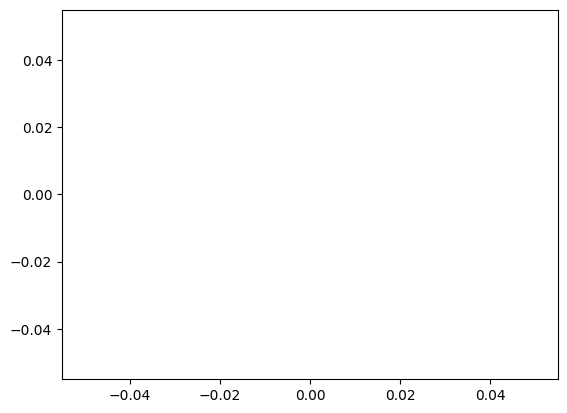

Z
[]


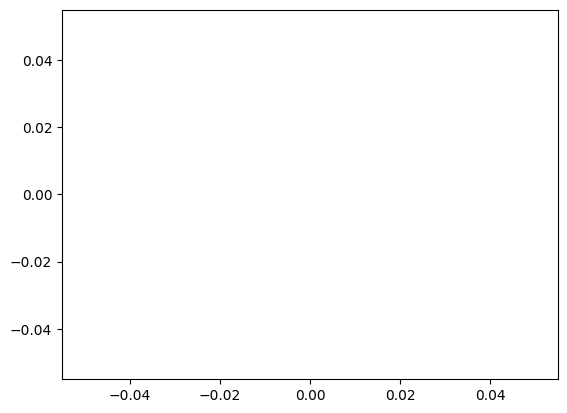

A
[]


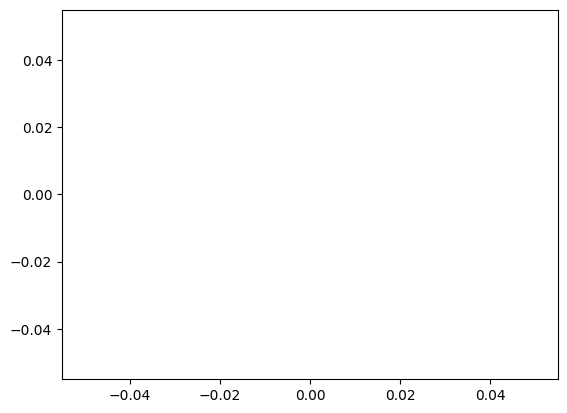

B
[]


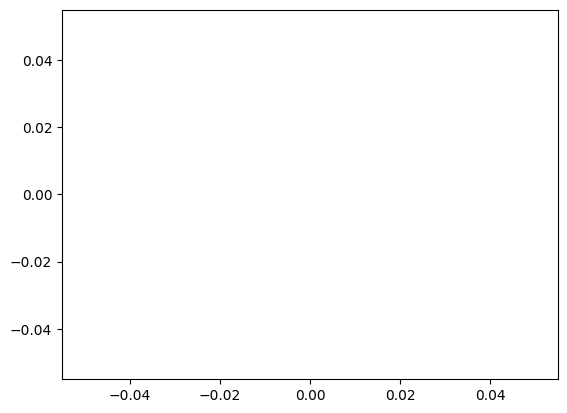

X_or_Y
[]


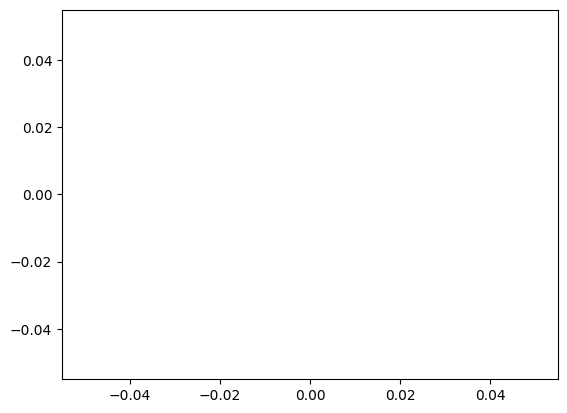

In [23]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
results = []

for index, button in enumerate(buttons):
    button_is_pressed_once = (df[f'{button}_num_presses_target'] == 1) & (df[f'{button}_num_presses_pred'] == 1)
    
    
    # Filtering rows where the button was pressed exactly once in both target and prediction
    target_button_is_pressed_once = target[button_is_pressed_once, -5+index, :]
    pred_button_is_pressed_once = pred[button_is_pressed_once, -5+index, :]
    
    # Calculating indices for the first and last button press in the target and prediction for each example
    index_of_first_1_target = np.argmax(target_button_is_pressed_once > 0.5, axis=1)
    index_of_first_1_pred = np.argmax(pred_button_is_pressed_once > 0.5, axis=1)
    index_of_last_1_target = (target_button_is_pressed_once.shape[1] - np.argmax(target_button_is_pressed_once[:, ::-1] > 0.5, axis=1))
    index_of_last_1_pred = (pred_button_is_pressed_once.shape[1] - np.argmax(pred_button_is_pressed_once[:, ::-1] > 0.5, axis=1))

    length_of_target_press = index_of_last_1_target - index_of_first_1_target
    length_of_pred_press = index_of_last_1_pred - index_of_first_1_pred
    
    unique, count = np.unique(length_of_pred_press - length_of_target_press, return_counts=True)
    print(button)
    print(np.array([unique,count]).T)

    plt.bar(unique,np.log(count+1))
    plt.show()
    


Investigate the differece in the angle of the joystick and c-stick.h

In [24]:
# Transform the target back to the the standard stick input. 
# 9 channels
target_no_transform = target[:, :4, :] - .5
target_no_transform[0:4, :] /= .5 / .725
target_no_transform[target_no_transform[:, 0:4, :] < 0] -= .2875 + 0.0125
target_no_transform[target_no_transform[:, 0:4, :] < 0] += .2875 - 0.0125
# target_no_transform *= target[:,4:8,:]
 
predicted_no_transform = pred[:, :4, :] - .5
predicted_no_transform[0:4, :] /= .5 / .725
predicted_no_transform[predicted_no_transform[:, 0:4, :] < 0] -= .2875 + 0.0125
predicted_no_transform[predicted_no_transform[:, 0:4, :] < 0] += .2875 - 0.0125

target_angle_JSTICK = np.arctan2(target_no_transform[:,0,:], target_no_transform[:,1,:]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_no_transform[:,0,:], predicted_no_transform[:,1,:]) * 180 / np.pi

target_radius_JSTICK = np.sqrt(target_no_transform[:,0,:] ** 2 + target_no_transform[:,1,:] ** 2)
pred_radius_JSTICK = np.sqrt(predicted_no_transform[:,0,:] ** 2 + predicted_no_transform[:,1,:] ** 2)

print(target_no_transform[:,0,:])
# # print(target_no_transform[:,1,:])
print()

print(predicted_no_transform[:,0,:])
# # print(predicted_no_transform[:,1,:])
# print()

# print(target_angle_JSTICK)
# print(predicted_angle_JSTICK)
# print()

# print(target_radius_JSTICK)
# print(pred_radius_JSTICK)

[[ 0.          0.          0.         ...  0.68749994  0.68749994
   0.68749994]
 [ 0.03749995  0.08749998  0.14999999 ...  0.          0.
   0.        ]
 [ 0.6375      0.6750001   0.68749994 ... -0.75       -0.75
  -0.75      ]
 ...
 [ 0.          0.          0.         ... -0.50775874 -0.50775874
  -0.50775874]
 [ 0.4741379   0.4741379   0.4741379  ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]

[[-0.04396346  0.00343581  0.00582188 ...  0.00070896 -0.02700338
  -0.04944909]
 [-0.04913077 -0.03216568 -0.03343466 ...  0.00985585  0.00709218
  -0.0401381 ]
 [-0.04386905  0.00063351  0.00144894 ... -0.02638853 -0.03061131
  -0.05090883]
 ...
 [ 0.0027051   0.00139499  0.0014773  ...  0.00032282 -0.02655932
  -0.04192507]
 [ 0.00343364  0.00144881  0.00170922 ... -0.02688378 -0.03316891
  -0.05023897]
 [-0.02982834 -0.0359498  -0.03270814 ...  0.00925732  0.00679874
  -0.03444025]]


Trasform the stick predictions back to the original inputs.

In [25]:
target_sticks_no_transform = target[:, :4] - .5
target_sticks_no_transform /= .5 / .725
target_sticks_no_transform[target_sticks_no_transform < 0] -= .2875 + 0.0125
target_sticks_no_transform[target_sticks_no_transform < 0] += .2875 - 0.0125
 
predicted_sticks_no_transform = pred[:, :4] - .5
predicted_sticks_no_transform /= .5 / .725
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] -= .2875 + 0.0125
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] += .2875 - 0.0125

# Multiply by 0 where the model predicted the stick input to be 0
# predicted_sticks_no_transform *= (pred[:,4:8] < .5)
predicted_sticks_no_transform *= (target[:,4:8] < .5)
# predicted_sticks_no_transform = np.where(predicted_sticks_no_transform == 0.0, 0.0, predicted_sticks_no_transform)

target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,[1,3]], target_sticks_no_transform[:,[0,2]]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,[1,3]], predicted_sticks_no_transform[:,[0,2]]) * 180 / np.pi

angle_difference_no_transform = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_angle_difference_no_transform = np.abs((angle_difference_no_transform + 180) % 360 - 180)

target_radius_squared_no_transform = target_sticks_no_transform[:,[0,2]] ** 2 + target_sticks_no_transform[:,[1,3]] ** 2
pred_radius_squared_no_transform = predicted_sticks_no_transform[:,[0,2]] ** 2 + predicted_sticks_no_transform[:,[1,3]] ** 2

radius_difference_no_trasform = np.abs(target_radius_squared_no_transform - pred_radius_squared_no_transform) ** (1/2)

print('JSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,0]))
print('CSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,1]))

print('JSTICK average radius difference', np.average(radius_difference_no_trasform[:,0]))
print('CSTICK average radius difference', np.average(radius_difference_no_trasform[:,1]))

JSTICK average angle difference 79.73781
CSTICK average angle difference 119.47359
JSTICK average radius difference 0.39485893
CSTICK average radius difference 0.02809561


In [26]:
target_sticks_no_transform = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32) * 0.008620689655172415 - .5
predicted_sticks_no_transform = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32) * 0.008620689655172415 - .5

# target_sticks_no_transform = target[:, :4] - .5
target_sticks_no_transform /= .5 / .725
target_sticks_no_transform[target_sticks_no_transform < 0] -= .2875 + 0.0125
target_sticks_no_transform[target_sticks_no_transform < 0] += .2875 - 0.0125
 
# predicted_sticks_no_transform = pred[:, :4] - .5
predicted_sticks_no_transform /= .5 / .725
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] -= .2875 + 0.0125
predicted_sticks_no_transform[predicted_sticks_no_transform < 0] += .2875 - 0.0125

# Multiply by 0 where the model predicted the stick input to be 0
# predicted_sticks_no_transform *= (pred[:,4:8] < .5)
# predicted_sticks_no_transform *= (target[:,4:8,:] < .5)
# predicted_sticks_no_transform = np.where(predicted_sticks_no_transform == 0.0, 0.0, predicted_sticks_no_transform)

target_angle_JSTICK = np.arctan2(target_sticks_no_transform[:,[1,3]], target_sticks_no_transform[:,[0,2]]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_sticks_no_transform[:,[1,3]], predicted_sticks_no_transform[:,[0,2]]) * 180 / np.pi

angle_difference_no_transform = (predicted_angle_JSTICK - target_angle_JSTICK) 
smallest_angle_difference_no_transform = np.abs((angle_difference_no_transform + 180) % 360 - 180)

target_radius_squared_no_transform = target_sticks_no_transform[:,[0,2]] ** 2 + target_sticks_no_transform[:,[1,3]] ** 2
pred_radius_squared_no_transform = predicted_sticks_no_transform[:,[0,2]] ** 2 + predicted_sticks_no_transform[:,[1,3]] ** 2

radius_difference_no_trasform = np.abs(target_radius_squared_no_transform - pred_radius_squared_no_transform) ** (1/2)

print('JSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,0]))
print('CSTICK average angle difference', np.average(smallest_angle_difference_no_transform[:,1]))

print('JSTICK average radius difference', np.average(radius_difference_no_trasform[:,0]))
print('CSTICK average radius difference', np.average(radius_difference_no_trasform[:,1]))




JSTICK average angle difference 106.06470476719666
CSTICK average angle difference 11.229940850441576
JSTICK average radius difference 0.41955110085585073
CSTICK average radius difference 0.030581350766831963


In [27]:
pred_binary_0 = (target[:,:4] == 0)
pred_stick_0 = predicted_sticks_no_transform == 0.


# print('Binary and continuous both predicted 0 JSTICK_X:', np.sum((target[:,4,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 JSTICK_Y:', np.sum((target[:,5,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 CSTICK_X:', np.sum((target[:,6,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)
# print('Binary and continuous both predicted 0 CSTICK_Y:', np.sum((target[:,7,:] > .5)) / (pred_binary_0.shape[0] * 60) * 100)

# print()

print('Binary and continuous both predicted 0 JSTICK_X:', np.sum(pred_binary_0[:,0] == pred_stick_0[:,0]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 JSTICK_Y:', np.sum(pred_binary_0[:,1] == pred_stick_0[:,1]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 CSTICK_X:', np.sum(pred_binary_0[:,2] == pred_stick_0[:,2]) / (pred_binary_0.shape[0] * 60) * 100)
print('Binary and continuous both predicted 0 CSTICK_Y:', np.sum(pred_binary_0[:,3] == pred_stick_0[:,3]) / (pred_binary_0.shape[0] * 60) * 100)

Binary and continuous both predicted 0 JSTICK_X: 5723.6984126984125
Binary and continuous both predicted 0 JSTICK_Y: 5883.111111111111
Binary and continuous both predicted 0 CSTICK_X: 5996.904761904762
Binary and continuous both predicted 0 CSTICK_Y: 5991.380952380952


In [28]:
import pandas as pd
import numpy as np

buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

first_and_last_df = pd.DataFrame(buttons, columns=['Button'])
for index, button in enumerate(buttons):
    first_frame_0 = (df[f'{button}_first_frame_target'] == 0)
    last_frame_0 = (df[f'{button}_last_frame_target'] == 0)
    
    first_and_last_df.loc[index, 'Ratio target[0]==0'] = first_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[0]==0'] = 1 - df.loc[first_frame_0, f'{button}_first_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[0]==1'] = df.loc[~first_frame_0, f'{button}_first_frame_pred'].mean()
    
    first_and_last_df.loc[index, 'Ratio target[-1]==0'] = last_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[-1]==0'] = 1-df.loc[last_frame_0, f'{button}_last_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[-1]==1'] = df.loc[~last_frame_0, f'{button}_last_frame_pred'].mean()
    
print('Table shows:')
print('- Percentage of test examples where the button was not pressed on the first or last frame')
print('- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.')

first_and_last_df


Table shows:
- Percentage of test examples where the button was not pressed on the first or last frame
- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.


,Button,Ratio target[0]==0,Acc target[0]==0,Acc target[0]==1,Ratio target[-1]==0,Acc target[-1]==0,Acc target[-1]==1
0,TRIGGER_LOGICAL,0.847619,1.0,0.0,0.809524,1.0,0.0
1,Z,1.000000,1.0,NaN,1.000000,1.0,NaN
2,A,0.990476,1.0,0.0,0.942857,1.0,0.0
3,B,0.961905,1.0,0.0,1.000000,1.0,NaN
4,X_or_Y,0.923810,1.0,0.0,0.942857,1.0,0.0


Check how accurately the model predicted model predicted each analog input being zero.

In [29]:
# correct_zero_stick = (pred[:,4:8] == 1) and (target[:,4:8] == 1)
# print('Accuracy of JSTICK_X = 0:', np.sum(correct_zero_stick[:,0]) / np.sum(target[:,4]) * 100)
# print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,1]) / np.sum(target[:,5]) * 100)
# print('Accuracy of CSTICK_X = 0:', np.sum(correct_zero_stick[:,2]) / np.sum(target[:,6]) * 100)
# print('Accuracy of JSTICK_Y = 0:', np.sum(correct_zero_stick[:,3]) / np.sum(target[:,7]) * 100)



In [30]:
print(np.max(pred[:,0:4]))
print(np.max(target[:,0:4]))

0.5732909
0.98275864


We make try to figure out how close the predicted stick vales were to the actual values. The possible stick values are discreet and we round the prediction to the nearest possibility.

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114]
[25 26 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
Good enough accuracy of JSICK_X 0.4978835978835978
Accuracy of JSTICK_X 0.1238095238095238


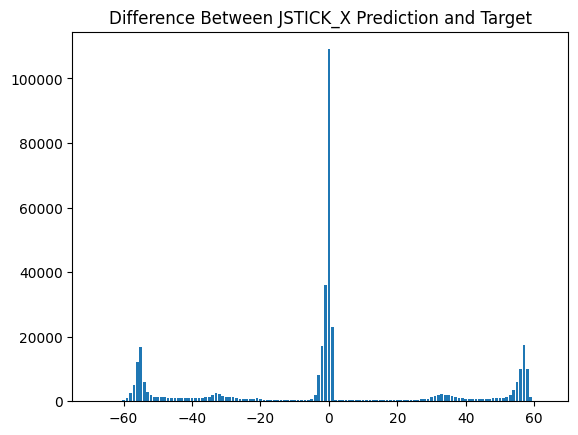

Good enough accuracy of JSTICK_Y 0.7219576719576719
Accuracy of JSTICK_Y 0.1753968253968254


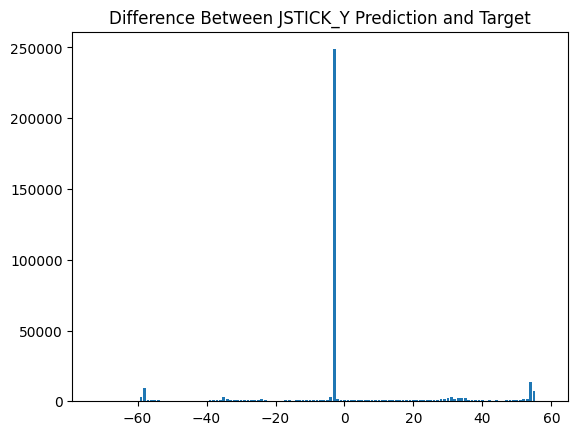

Good enough accuracy of CSTICK_X 97.5589947089947
Accuracy of CSTICK_X 0.5452380952380953


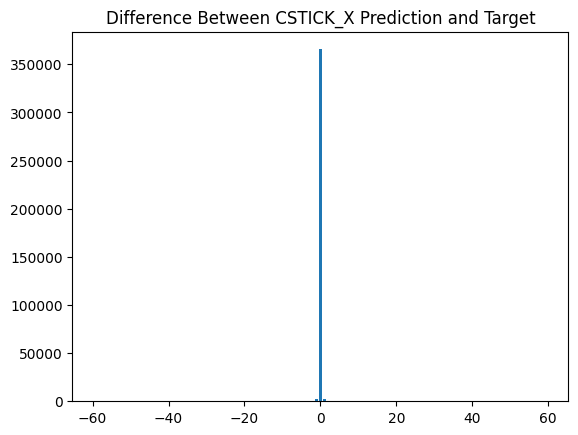

Good enough accuracy of CSTICK_Y 0.06666666666666667
Accuracy of CSTICK_Y 0.01798941798941799


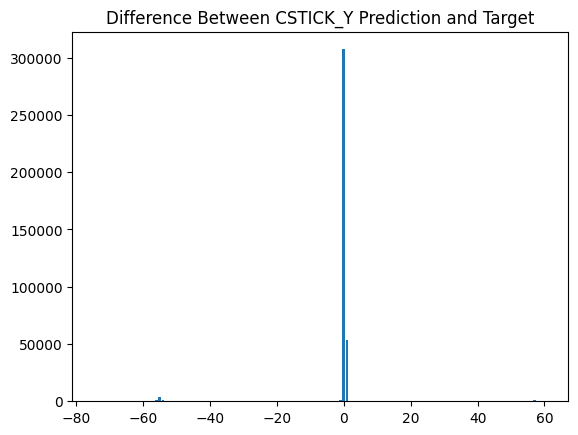

In [31]:
integer_stick_targets = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32)
integer_stick_pred = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32)

print(np.unique(integer_stick_targets))
print(np.unique(integer_stick_pred))


unique, counts = np.unique(integer_stick_pred[:,0] - integer_stick_targets[:,0], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of JSICK_X', np.sum(counts[58-2:58+2]) / np.sum(counts) * 100)
print('Accuracy of JSTICK_X', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between JSTICK_X Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,1] - integer_stick_targets[:,1], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of JSTICK_Y', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of JSTICK_Y', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between JSTICK_Y Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,2] - integer_stick_targets[:,2], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of CSTICK_X', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of CSTICK_X', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between CSTICK_X Prediction and Target')
plt.show()

unique, counts = np.unique(integer_stick_pred[:,3] - integer_stick_targets[:,3], return_counts=True)
plt.bar(unique, counts)
print('Good enough accuracy of CSTICK_Y', np.sum(counts[58-2:58+2]) / np.sum(counts)* 100)
print('Accuracy of CSTICK_Y', counts[58] / np.sum(counts)* 100)
plt.title('Difference Between CSTICK_Y Prediction and Target')
plt.show()




Accuracy of predicting 0

Overall accuracy of Sticks and buttons.

In [32]:
integer_stick_targets = np.round(target[:,0:4] / 0.008620689655172415 ).astype(np.int32)
integer_stick_pred = np.round(pred[:,0:4] / 0.008620689655172415).astype(np.int32)



n = 10

buttons = ['JSTICK_X', 'JSTICK_Y', 'CSTICK_X', 'CSTICK_Y']
# buttons = ['X_or_Y']


stick_accuracy_df = pd.DataFrame(np.arange(n,dtype=np.int16),columns=['How Close'])
# print(summary_df)


for j in range(4):
    unique, counts = np.unique(integer_stick_pred[:,0] - integer_stick_targets[:,0], return_counts=True)
    data = []
    num = np.sum(counts)
    for i in range(n):
        mask = np.abs(unique) <= i
        data += [np.sum(counts[mask]) / num * 100]
    stick_accuracy_df[buttons[j]] = data
        
print(stick_accuracy_df)     




   How Close   JSTICK_X   JSTICK_Y   CSTICK_X   CSTICK_Y
0          0  28.847884  28.847884  28.847884  28.847884
1          1  44.496296  44.496296  44.496296  44.496296
2          2  49.162698  49.162698  49.162698  49.162698
3          3  51.419048  51.419048  51.419048  51.419048
4          4  52.044974  52.044974  52.044974  52.044974
5          5  52.304762  52.304762  52.304762  52.304762
6          6  52.549471  52.549471  52.549471  52.549471
7          7  52.784392  52.784392  52.784392  52.784392
8          8  53.028571  53.028571  53.028571  53.028571
9          9  53.231481  53.231481  53.231481  53.231481


In [33]:
import numpy as np
import pandas as pd

# Example data setup (make sure you have your actual data in these variables)
# target = np.random.randint(0, 2, (100, 9))  # Example target array
# pred = np.random.random((100, 9))  # Example predictions array
buttons = [ 'TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

# Initializing the DataFrame
button_accuracy_df = pd.DataFrame(columns=['Button', 'Accuracy', 'Acc of 0', 'Acc of 1'])

target_buttons = target[:, 4:]
pred_buttons = pred[:, 4:] > 0.5
total = target_buttons.shape[0] * 3600

# Computing accuracies and filling the DataFrame
rows = []  # List to hold row data

for i, button in enumerate(buttons):
    correct_predictions = np.sum(target_buttons[:, i] == pred_buttons[:, i])
    correct_zeros = np.sum((target_buttons[:, i] == 0) & (pred_buttons[:, i] == 0))
    correct_ones = np.sum((target_buttons[:, i] == 1) & (pred_buttons[:, i] == 1))

    accuracy = correct_predictions / total * 100
    acc_of_0 = correct_zeros / np.sum(target_buttons[:, i] == 0) * 100 if np.sum(target_buttons[:, i] == 0) > 0 else 0
    acc_of_1 = correct_ones / np.sum(target_buttons[:, i] == 1) * 100 if np.sum(target_buttons[:, i] == 1) > 0 else 0

    rows.append({
        'Button': button,
        'Accuracy': accuracy,
        'Acc of 0': acc_of_0,
        'Acc of 1': acc_of_1
    })

# Use concat to add all new rows to the DataFrame at once
button_accuracy_df = pd.concat([button_accuracy_df, pd.DataFrame(rows)], ignore_index=True)

# Output the DataFrame
print(button_accuracy_df)


            Button   Accuracy    Acc of 0   Acc of 1
0  TRIGGER_LOGICAL  51.362698   14.276779   87.08302
1                Z  66.925926    0.000000  100.00000
2                A  98.275132    0.000000  100.00000
3                B  96.110582    0.000000  100.00000
4           X_or_Y  97.725926  100.000000    0.00000


In [34]:
# mask = integer_stick_targets[:,0:4] == 58

# unique, counts = np.unique(integer_stick_pred[mask[:,0]] - integer_stick_targets[mask[:,0]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between JSTICK_X Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,1]] - integer_stick_targets[mask[:,1]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between JSTICK_Y Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,2]] - integer_stick_targets[mask[:,2]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between CSTICK_X Prediction and Target at 0')
# plt.show()

# unique, counts = np.unique(integer_stick_pred[mask[:,3]] - integer_stick_targets[mask[:,3]], return_counts=True)
# plt.bar(unique, counts)
# print('Good enough accuracy of JSICK_X at 0', np.sum(counts[58-2:58+2]) / np.sum(counts))
# print('Accuracy of JSTICK_X at 0', counts[58] / np.sum(counts))
# plt.title('Difference Between CSTICK_Y Prediction and Target at 0')
# plt.show()

In [35]:
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

for i in range(4):
    # bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
    mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
    print('input',i)
    # print('BCE', bce)
    print('MSE', mse)
    print()
    
for i in range(4,13):
    bce = log_loss(target[:,i,:].flatten(),pred[:,i,:].flatten())
    mse = mean_squared_error(target[:,i,:].flatten(),pred[:,i,:].flatten())
    print('input',i)
    print('BCE', bce)
    print('MSE', mse)
    print()

input 0
MSE 0.080571145

input 1
MSE 0.039684083

input 2
MSE 0.0019418565

input 3
MSE 0.0066611217

input 4
BCE 0.6928679752974678
MSE 0.2498603

input 5
BCE 0.6350870235691695
MSE 0.22149977

input 6
BCE 0.08723373258028257
MSE 0.016955366

input 7
BCE 0.16482321132797703
MSE 0.037400816

input 8
BCE 0.10862952595207417
MSE 0.022225142

input 9
BCE 0.014247773417085266
MSE 0.0019587788

input 10
BCE 0.08584677266032285
MSE 0.016550276

input 11
BCE 0.03281932406450128
MSE 0.005200671

input 12
BCE 0.12661970826787589
MSE 0.026844893



In [36]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) #* 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) #* 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
# smallest_angle_difference = (angle_difference + 180) % 360 - 180=

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 1.9998085
CSTICK average angle 0.18859246


In [37]:
target_angle = np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2) * 180 / np.pi
predicted_angle = np.arctan2((pred[:,[0,2]] - .5) * 2, (pred[:,[1,3]] - .5) * 2) * 180 / np.pi
# predicted_angle = np.arctan2(pred[:,[0,2]], pred[:,[1,3]]) * 180 / np.pi

angle_difference = (predicted_angle - target_angle) # between -2pi and 2pi
# smallest_angle_difference = (angle_difference + np.pi) % (2 * np.pi) - np.pi
smallest_angle_difference = (angle_difference + 180) % 360 - 180
smallest_angle_difference *= (np.pi / 180)

# n,i = 4,0
# print(target_angle[n,i])
# print()
# print(predicted_angle[n,i])
# print()
# print(smallest_angle_difference[n,i])

print('JSTICK average angle', np.average(np.abs(smallest_angle_difference[:,0])))
print('CSTICK average angle', np.average(np.abs(smallest_angle_difference[:,1])))

JSTICK average angle 1.9998085
CSTICK average angle 0.18859246


In [38]:
target_radius_squared = target[:,[0,2]] ** 2 + target[:,[1,3]] ** 2
pred_radius_squared = pred[:,[0,2]] ** 2 + pred[:,[1,3]] ** 2

radius_difference = target_radius_squared - pred_radius_squared

print('JSTICK average radius', np.average(np.abs(radius_difference[:,0])))
print('CSTICK average radius', np.average(np.abs(radius_difference[:,1])))

JSTICK average radius 0.25609577
CSTICK average radius 0.024950307


In [39]:
unique_values = np.unique((target[:,0] - .5) * 2)
print(unique_values.shape)
print(np.diff(unique_values))



(115,)
[0.01724142 0.01724124 0.01724148 0.01724142 0.0172413  0.01724142
 0.0172413  0.01724142 0.01724148 0.0172413  0.01724142 0.0172413
 0.01724142 0.01724148 0.01724124 0.01724148 0.0172413  0.01724148
 0.01724136 0.01724136 0.01724136 0.01724136 0.01724142 0.01724142
 0.01724136 0.01724136 0.01724136 0.01724142 0.01724136 0.01724136
 0.01724136 0.01724136 0.01724148 0.01724136 0.01724136 0.01724136
 0.01724136 0.01724148 0.01724136 0.01724136 0.01724136 0.01724136
 0.01724142 0.01724142 0.01724136 0.01724136 0.01724136 0.01724136
 0.01724142 0.01724136 0.01724136 0.01724142 0.01724136 0.01724142
 0.01724136 0.01724136 0.01724142 0.01724136 0.01724136 0.01724136
 0.01724136 0.01724136 0.01724148 0.01724136 0.01724136 0.01724136
 0.01724136 0.01724148 0.01724136 0.01724136 0.01724136 0.01724136
 0.01724148 0.01724136 0.01724136 0.01724136 0.01724136 0.01724148
 0.01724124 0.01724148 0.01724124 0.01724148 0.01724148 0.01724124
 0.01724148 0.01724124 0.01724148 0.01724136 0.01724136 

In [40]:
import math
print((2 * np.pi) * .017545)
print((2 * np.pi) * .017545 * math.sqrt(2))


0.11023848621446584
0.15590076229997707


In [41]:
unique_values = np.unique(np.arctan2((target[:,[0,2]] - .5) * 2, (target[:,[1,3]] - .5) * 2))
print(unique_values.shape)
print(np.diff(unique_values))
print(np.average(np.diff(unique_values)))

(3866,)
[0.00034928 0.00036263 0.00037694 ... 0.00039196 0.00073957 0.01886582]
0.0016208716


In [42]:
unique_values = np.unique(target[:,4:])
print(unique_values)
# print(np.diff(unique_values))
# print(np.average(np.diff(unique_values)))

[0. 1.]


In [43]:
 # class CustomLoss(nn.Module):==
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         self.BCE = nn.BCEWithLogitsLoss(reduction='sum')  # Consider using weighted BCE if needed
#         self.MSE = nn.MSELoss(reduction='sum')
#         self.bin_threshold = 2
#         # Self.bin_threshold bins to the left and right should account for the barely close enough threshold
#         self.barely_close_enough = (.5 + self.bin_threshold) * 0.00862#
#         self.scale_factor = - math.log(.5) / self.barely_close_enough ** 2
        
#     def forward(self, pred, target):
#         # Calculating losses
#         mse_loss = self.MSE(torch.sigmoid(pred[:,0:4,0:60]), target[:,0:4,0:60]) 
#         bce_loss = self.BCE(pred[:,4:,0:60], target[:,4:,0:60])
        
#         # Total loss
#         return mse_loss * 100 + bce_loss
import math
(- math.log(.5) / (4.5* 0.00862) ** 2) ** (1/2)

# ((- math.log(.5) * 100) ** (1/2)) / 0.00862 - .5

21.46312480427166

In [44]:

segment = np.array([[0,0,0,0,1], [0,1,1,0,0],[1,0,0,0,1],[0,0,0,1,1],[1,1,1,0,0]])

print(segment.shape)
prepend = np.expand_dims(segment[:, 0], axis=1)
print(prepend)
transitions= np.abs(np.diff(segment[:], axis=1, prepend=prepend))

print(transitions)

(5, 5)
[[0]
 [0]
 [1]
 [0]
 [1]]
[[0 0 0 0 1]
 [0 1 0 1 0]
 [0 1 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]]
